In [85]:
from collections import Counter
import os
import pandas as pd
from gensim.models import Phrases, phrases
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
from collections import Counter
from extractFeatures import *


def getgramsID(txt):
    infile = open(txt,'r')
    lines = infile.readlines()
    infile.close()
    allgrams = {}
    for line in lines: 
        line = line.split('--')
        tcp_id = line[0].split(':')[0].strip()
        allgrams[tcp_id] = []
        ngrams = line[1].strip()
        if '_' in ngrams: 
            ngrams = ngrams.strip().split(' ')
            for n in ngrams:
                allgrams[tcp_id].append(n)
        else: continue
    return allgrams 

def wordcloud(counts,title,mask,maskable_image, colormap):
    if mask: 
        word_cloud = WordCloud(background_color = "white", width=3000, height=2000, max_words=200, mask = maskable_image, colormap=colormap, collocations=False).generate_from_frequencies(counts)
    else: 
        word_cloud = WordCloud(background_color = "white", width=3000, height=2000, max_words=200, collocations=True).generate_from_frequencies(counts)
    plt.figure(figsize=(20,10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.title(title,fontsize=20)
    plt.show()

''' 
Mask creation code from this tutorial: https://www.holisticseo.digital/python-seo/word-cloud/
'''
import numpy as np 
from PIL import Image
mask = np.array(Image.open('/Users/amycweng/Digital Humanities/Early-Modern-London/Other_Files/heart.png'))
def transform_zeros(val):
    if val == 0:
        return 255
    else: 
        return val
maskable_image = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
for i in range(len(mask)):
    maskable_image[i] = list(map(transform_zeros, mask[i]))

In [13]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/sermons.csv')
tcpIDs = [ _ for _ in csv_data['id']]
bigramdata = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs)
bigramtexts = list(bigramdata.values())
bigramnames = list(bigramdata.keys())
print(len(bigramnames))
''' 
Gets bigrams and trigrams that appear at least TWICE

https://radimrehurek.com/gensim_3.8.3/models/phrases.html 
'''
sentences = []
for t in bigramtexts:
    words = t.split(' ')
    sentences.append(words)

grammodel = Phrases(sentences, min_count=2, threshold= 0, scoring='npmi', connector_words=phrases.ENGLISH_CONNECTOR_WORDS)
print('bigram model trained')

70
bigram model trained


In [14]:
'''For charity texts''' 
groups = {0: 'charity|charitable', 
        1: 'beneficience|bequeath|bestow|liberality|benevolence|goodwill| alm | almes |kindness|almsdeed',
        2: 'poor|poverty|rich|wealth|beggar|orphan|needy|labourer|impotent|bankrupt|penury|meanness|prosperity|bounty|impouerish|impoverish',
        3: 'rate|usury|usurer|money|commodity|talon|talent|coin|bullion|exchange|shilling|farthing| pound |penny|purchase',
        4: 'credit|creditor|loan|lend',
        5: ' debt|debtor|borrow|pledge|pawn',
        6: 'industry|industrious|thrift|labor|labour|occupation|profit|profitable|commodious',
        7: 'prison|imprisonment',
        8: 'hospital|almshouse|orphanage',
        9: 'city|citizen|london',
        10: 'vagrant|vagrancy'
        }
searchwords = []
for part in groups.values(): 
    searchwords.extend([word.strip() for word in part.split('|')])
# '''For plays''' 
# searchwords = ['credit','creditors','loan','lending','lend','new','nevv','novelty','novel',
#     'nouel','nouelty','nouelties','novelties','profits','profit',
#     'wealth','vvealth','merit','commodity','commoditie','money',
#     'monies','thrift','thrifty','industry'
# ]
gramDict = {}
gramFreqs = {}
for key in searchwords: 
    gramDict[key] = []
    gramFreqs[key] = 0
    
name = 'charity'
# name = 'plays'
storeGramFile = open(f'gramsEach{name}Text.txt','w')
count = 0
for idx, text in enumerate(bigramtexts):
    #for outputting to txt file, specify here
    textGrams = []
    totalgrams = 0
    text = text.strip().split(' ')
    gcount = Counter(b for b in grammodel[text] if len(b.split("_")) > 1)
    for gram,freq in dict(gcount).items():
        totalgrams += freq
        for s in searchwords: 
            if s in gram.split('_'):
                gramDict[s].append(gram)
                gramFreqs[s] += freq
                textGrams.append(" ".join([gram]*freq))

    storeGramFile.write(f'{bigramnames[idx]}: {totalgrams} -- {" ".join(textGrams)}\n')
    count += 1
    if count%10 == 0:
        print(count, "files processed")
storeGramFile.close()
with open(f'{name}Grams.txt', 'w+') as outfile: 
    for s in searchwords: 
        outfile.write(f"{s}: {gramFreqs[s]} occurrences\n\t\t{' '.join(gramDict[s])}\n")

print('processing complete')

10 files processed
20 files processed
30 files processed
40 files processed
50 files processed
60 files processed
70 files processed
processing complete


In [80]:
charitygrams = getgramsID('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/gramsEachcharityText.txt')

In [96]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/sermons.csv')
tcpIDs = [ _ for _ in csv_data['id']]
textInfo = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs)
textLengths = {}
for tcpID, text in textInfo.items(): 
    textLengths[tcpID] = len(text.split(' '))

In [105]:
# for tcpID,gramList in charitygrams.items(): 
#     newgramlist = []
#     for gram in gramList: 
#         if re.search('charity|charitable|alm|poor|poverty|',gram): 
#             newgramlist.append(gram)
#     charitygrams[tcpID] = newgramlist
xValues = [] 
yValues = [] 
for tcpID, gramList in charitygrams.items(): 
    totalGramLength = 0
    for gram in gramList: 
        gram = gram.split('_')
        totalGramLength += len(gram)
    yValues.append(totalGramLength/textLengths[tcpID]) # number of grams
    xValues.append(len(charity_citations[tcpID])) # number of charity citations 
    if totalGramLength/textLengths[tcpID] > 0.020: 
        print(tcpID)
        print(len(charity_citations[tcpID]))
        print(find_titles([tcpID],idToTitle))
        print('\n')

A02585
0
["A02585: The righteous mammon an hospitall-sermon preach't in the solemne assembly"]


A15012
15
['A15012: The poore mans advocate, or, A treatise of liberality to']




R-squared: 0.074084
P-value: 0.022639


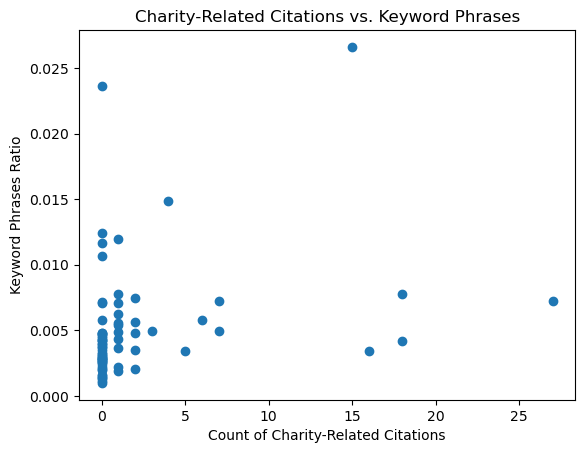

In [102]:
from scipy import stats
reg = stats.linregress(xValues, yValues)
print(f"R-squared: {reg.rvalue**2:.6f}")
print(f"P-value: {reg.pvalue:.6f}")
# add points + line
plt.scatter(xValues,yValues)
# plt.plot(xValues, int(a)*xValues+b)
plt.xlabel("Count of Charity-Related Citations")
plt.ylabel("Keyword Phrases Ratio")
plt.title("Charity-Related Citations vs. Keyword Phrases")
plt.show()

[('be_rich', 128), ('rich_man', 115), ('poor_man', 66), ('bestow_upon', 45), ('his_wealth', 42), ('be_poor', 36), ('be_bestow', 34), ('wealth_be', 31), ('bestow_it', 28), ('this_city', 28), ('labour_to_see', 27), ('his_labour', 24), ('god_bestow', 24), ('labour_to_get', 23), ('not_profit', 23), ('their_labour', 23), ('your_labour', 22), ('we_labour', 22), ('labour_to_have', 22), ('our_labour', 22), ('he_labour', 22), ('he_bestow', 22), ('poor_sinner', 22), ('be_profitable', 21), ('his_credit', 21), ('therefore_labour', 21), ('must_labour', 20), ('thy_wealth', 20), ('labour_after', 19), ('rich_or_poor', 18), ('city_be', 18), ('that_city', 18), ('profit_not', 18), ('give_to_the_poor', 18), ('what_profit', 17), ('rich_mercy', 17), ('labour_not', 16), ('worldly_wealth', 16), ('have_bestow', 16), ('make_rich', 16), ('poor_soul', 16), ('high_rate', 16), ('into_prison', 16), ('have_purchase', 16), ('poor_in_spirit', 15), ('our_profit', 15), ('city_of_god', 15), ('charity_be', 15), ('bestow_on

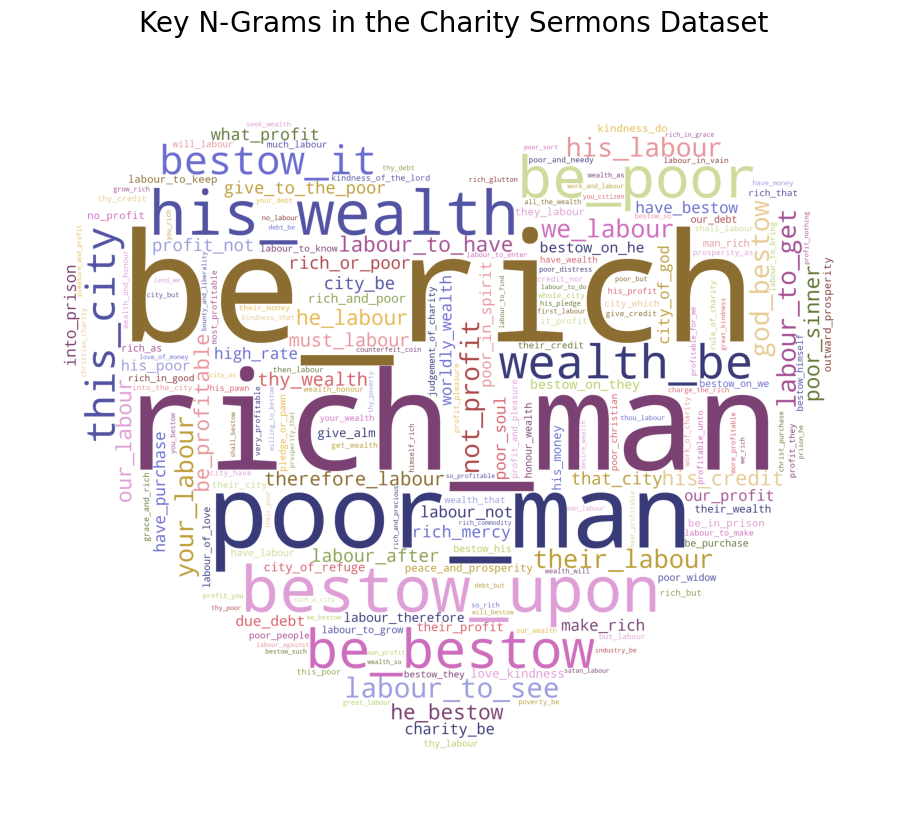

In [86]:
counts = []
for tcpID, gramList in charitygrams.items(): 
    counts.extend(gramList)
counts = Counter(counts)
print(counts.most_common(n=50))
wordcloud(counts,"Key N-Grams in the Charity Sermons Dataset",True,maskable_image,'tab20b')

In [17]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/sermons.csv')
tcpIDs = [ _ for _ in csv_data['id']]
charitygrams = getgramsID('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/gramsEachcharityText.txt')
categories = list(set([value[0] for value in audience.values()]))
gramsPerCategory = {key: [] for key in categories}
for tcpID, grams in charitygrams.items(): 
    if audience[tcpID][0] in ['parliament','house of lords','house of commons']: 
        gramsPerCategory['parliament'].extend(grams)
    else: 
        gramsPerCategory[audience[tcpID][0]].extend(grams)
for category, grams in gramsPerCategory.items(): 
    if len(grams) == 0: continue
    print(f'{category}: {Counter(grams).most_common(n=10)}')

wedding: [('have_wealth', 4), ('worldly_wealth', 3), ('man_without_money', 3), ('god_bestow', 3), ('have_bestow', 3), ('their_profit', 3), ('strong_city', 2), ('possession_wealth', 2), ('wife_for_wealth', 2), ('man_rich', 2)]
company: [('present_profit', 6), ('his_money', 2), ('fence_city', 2), ('labour_the_conversion', 2), ('poor_man', 2), ('poor_may', 2), ('their_profit', 2), ('must_labour', 2), ('how_poor', 2), ('profit_and_pleasure', 2)]
funeral: [('fifty_pound', 4), ('her_charity', 3), ('rich_man', 2), ('bequeath_it', 2), ('charity_as', 2), ('such_poor', 2), ('relief_of_the_poor', 2), ('have_labour', 2), ('lend_we', 2), ('wealth_of_this', 2)]
Inns of Court/local: [('be_rich', 24), ('rich_man', 16), ('therefore_labour', 9), ('your_labour', 9), ('his_wealth', 9), ('bestow_upon', 8), ('thy_wealth', 8), ('labour_to_see', 8), ('his_credit', 8), ('labour_to_have', 7)]
local: [('rich_man', 67), ('be_rich', 45), ('poor_man', 44), ('bestow_upon', 26), ('this_city', 22), ('his_wealth', 21),

In [94]:
for tcpID, gramlist in charitygrams.items(): 
    for gram in gramlist: 
        if 'fifty' in gram: 
            print(tcpID)
            print(gram)
            print(find_titles([tcpID],idToTitle))

A01531
fifty_pound
["A01531: The decease of Lazarus Christ's friend A funerall sermon on"]
A01531
fifty_pound
["A01531: The decease of Lazarus Christ's friend A funerall sermon on"]
A01531
fifty_pound
["A01531: The decease of Lazarus Christ's friend A funerall sermon on"]
A01531
fifty_pound
["A01531: The decease of Lazarus Christ's friend A funerall sermon on"]


In [30]:
import re 
def getCounts(txt): 
    infile = open(txt,'r')
    lines = infile.readlines()
    infile.close()
    count = 0
    for line in lines:
        num = re.search(r'\b\d+\b',line)
        if num: 
            count += int(num.group())
    return count 
totalcount = getCounts('gramsEachcharityText.txt')
bgcount = getCounts('charityGrams.txt')
print(f'{bgcount} DIV {totalcount} = {bgcount/totalcount}')

5941 DIV 993505 = 0.005979839054660017
